<a href="https://colab.research.google.com/github/SaturdaysAI/Workshops/blob/main/taller_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehículos autónomos: Detectando los obstáculos de la ciudad

Bienvenido al ejercicio práctico del taller de vehículos autónomos de Saturdays.AI y Epitech. Este Notebook es una adaptación de un artículo del autor [Herving Philipe](https://medium.com/@hervindphilipe).

**Descripción del problema**

Crea tu propio sistema de detección de objetos con bordes delimitadores. Estos sistemas son utilizados por los coches autónomos para la detección peatones, otros vehículos o señales de tráfico.

**Competencias**

Al final de esta práctica serás capaz de manejar notebooks de Python, ejecutar modelos de inteligencia artificial y generar modelos de detección de objetos. Estos modelos son ampliamente utilizados ámbitos como la medicina, la ecología o la seguridad.

En esta práctica vamos a realizar una demo de los dos artículos referidos al modelo YOLO, los cuales puedes encontrar [aquí](https://arxiv.org/abs/1506.02640) y [aquí](https://arxiv.org/abs/1612.08242). En concreto, utilizaremos técnicas de IA para generar un detector de vehículos.

Lo primero que haremos será configurar el entorno de ejecución. Este representará la máquina sobre la cual ejecutaremos nuestros modelos. Debido a que trabajaremos con modelos muy grandes, normalmente será más conveniente trabajar sobre una GPU (gráfica) que sobre una CPU debido a su potecia de cálculo.

Para cambiar tu entorno de ejecución a GPU selecciona en la parte superior del notebook la opción **Entorno de ejecución** y **Cambiar tipo de entorno de ejecución**. En el desplegable **Acelerador por hardware** selecciona la opción **GPU** y dale a **Guardar**. Ya tienes todo listo para comenzar a trabajar.

Lo primero que harás será asociar tu cuenta de Google Drive a este notebook para así alojar el material que utilizarás para construir tu detector de objetos. Al ejecutar la siguiente celda deberás aceptar el acceso, momento en el que recibirás un código que deberás introducir para finalizar la sincronización.

Lo primero será clonar el repositorio en el que se encuentra el modelo original. Utilizaremos la versión YOLOv3 para la realización de esta práctica.

In [ ]:
!git clone https://github.com/ultralytics/yolov3

Importamos las librerías necesarias para la construcción y ejecución del modelo.

In [ ]:
%cd yolov3
import time
import glob
import torch
import os

import argparse
from sys import platform

from models import *
from utils.datasets import *
from utils.utils import *

from IPython.display import HTML
from base64 import b64encode

En este apartado revisaremos algunas herramientas de diseño de un conjunto de entrenamiento para la clasificación de objetos como por ejemplo [MakeSense](https://www.makesense.ai/).

Establecemos el *parser* que permitirá utilizar el CUDA (gráfica) para agilizar el modelo. El modeo YOLO es muy costoso de entrenar, con lo que optaremos por utilizar los pesos preentrenados.

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', type=str, default='cfg/yolov3-spp.cfg', help='*.cfg path')
parser.add_argument('--names', type=str, default='data/coco.names', help='*.names path')
parser.add_argument('--weights', type=str, default='weights/yolov3-spp-ultralytics.pt', help='weights path')

parser.add_argument('--img-size', type=int, default=416, help='inference size (pixels)')
parser.add_argument('--conf-thres', type=float, default=0.3, help='object confidence threshold')
parser.add_argument('--iou-thres', type=float, default=0.6, help='IOU threshold for NMS')


parser.add_argument('--device', default='', help='device id (i.e. 0 or 0,1) or cpu')


parser.add_argument('--classes', nargs='+', type=int, help='filter by class')
parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
opt = parser.parse_args(args = [])

weights = opt.weights
img_size =  opt.img_size

# Initialize
device = torch_utils.select_device(device='cpu' if ONNX_EXPORT else opt.device)

# Initialize model
model = Darknet(opt.cfg, img_size)

# Load weights
attempt_download(weights)
if weights.endswith('.pt'):  # pytorch format
    model.load_state_dict(torch.load(weights, map_location=device)['model'])
else:  # darknet format
    load_darknet_weights(model, weights)

model.to(device).eval();

# Get names and colors
names = load_classes(opt.names)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

%cd ..

Definimos una función que nos permitirá cargar un video y convertirlo en frames. Sobre cada frame ejecutaremos el modelo para obtener las posibles cajas delimitadoras. Debido a que obtendremos un gran conjunto de cajas delimitadoras que no son de utilidad implementamos también el método de supresión no-máxima.

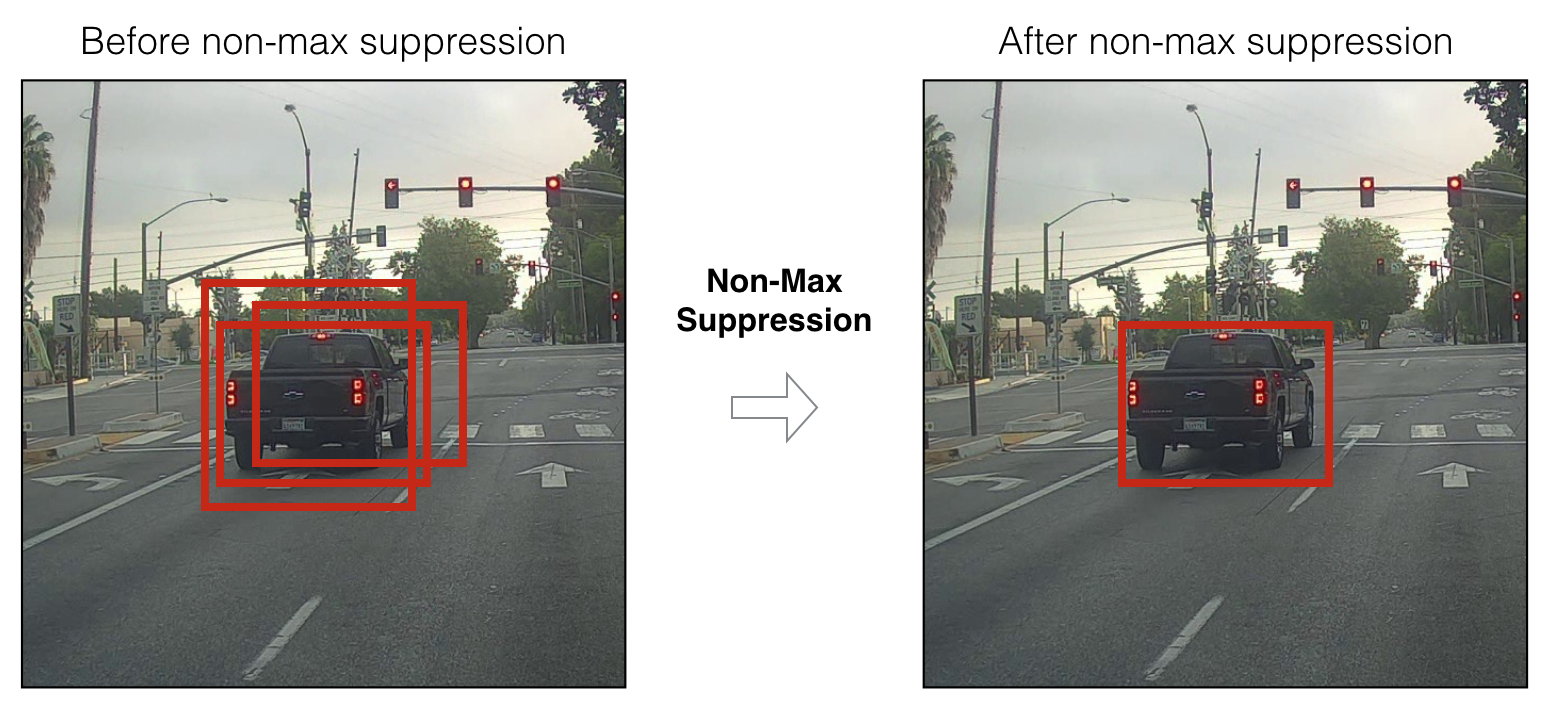

Finalmente podremos visualizar todas las cajas encontradas por el modelo.

In [ ]:
def predict_one_video(path_video, output_dir = 'output'): 

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap  = cv2.VideoCapture(path_video)
    _, img0 = cap.read()

    save_path = os.path.join(output_dir, os.path.split(path_video)[-1]) 
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'MP4V'), fps, (w, h))

    while img0 is not None: 

        # Padded resize
        img = letterbox(img0, new_shape=opt.img_size)[0]

        # Convert
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3xHxW
        img = np.ascontiguousarray(img)

        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        pred = model(img)[0]
        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            im0 = img0 ##### Ganti im0s menjadi img0

            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Write results
                for *xyxy, conf, cls in det:
                    label = '%s %.2f' % (names[int(cls)], conf)
                    plot_one_box(xyxy, im0, label=label, color=colors[int(cls)])

        vid_writer.write(im0)
        _, img0 = cap.read()

    vid_writer.release()

    return save_path


Descarga algunos vídeos de muestra para probar el modelo.

In [ ]:
!mkdir -p input_video
!mkdir -p output_compressed

!git clone https://github.com/vindruid/yolov3-in-colab.git
!cp -r "yolov3-in-colab"/input_video/* ./input_video/

Carga de un video de ejemplo en el notebook.

In [ ]:
path_video = os.path.join("input_video","opera_house.mp4")
save_path = predict_one_video(path_video)

# Show video
mp4 = open(path_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# compress video
compressed_path = os.path.join("output_compressed", os.path.split(save_path)[-1])
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

A continuación prueba de subir tu propio video (en formato mp4) a la carpeta *input_video*. Puedes grabarte a ti mismo o subir, por ejemplo, un video de tráfico para poner a prueba como funcionaría el modelo para un coche autónomo.

In [ ]:
path_video = os.path.join("input_video", "GTAVGangWar.mp4")
save_path = predict_one_video(path_video)

# compress video
compressed_path = os.path.join("output_compressed", os.path.split(save_path)[-1])
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)